In [1]:
import torch
from PIL import Image
import random
from diffusers import (
    DiffusionPipeline,
    AutoencoderKL,
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    StableDiffusionLatentUpscalePipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
    DPMSolverMultistepScheduler,  # <-- Added import
    EulerDiscreteScheduler  # <-- Added import
)
import time


/Users/lsb/jupyterlab/.direnv/python-3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preferred_dtype = torch.float32
preferred_device = "cpu"
BASE_MODEL = "SG161222/Realistic_Vision_V5.1_noVAE"
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=preferred_dtype).to(preferred_device)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=preferred_dtype).to(preferred_device)
main_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    safety_checker=None,
    torch_dtype=preferred_dtype,
).to(preferred_device)
#image_pipe = StableDiffusionControlNetImg2ImgPipeline(**main_pipe.components)

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.49it/s]


In [3]:
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}


In [4]:
def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size

    # Calculate dimensions to crop to the center
    new_dimension = min(width, height)
    left = (width - new_dimension)/2
    top = (height - new_dimension)/2
    right = (width + new_dimension)/2
    bottom = (height + new_dimension)/2

    # Crop and resize
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)

    return img

In [5]:
def common_upscale(samples, width, height, upscale_method, crop=False):
        if crop == "center":
            old_width = samples.shape[3]
            old_height = samples.shape[2]
            old_aspect = old_width / old_height
            new_aspect = width / height
            x = 0
            y = 0
            if old_aspect > new_aspect:
                x = round((old_width - old_width * (new_aspect / old_aspect)) / 2)
            elif old_aspect < new_aspect:
                y = round((old_height - old_height * (old_aspect / new_aspect)) / 2)
            s = samples[:,:,y:old_height-y,x:old_width-x]
        else:
            s = samples

        return torch.nn.functional.interpolate(s, size=(height, width), mode=upscale_method)

In [6]:
def upscale(samples, upscale_method, scale_by):
        #s = samples.copy()
        width = round(samples["images"].shape[3] * scale_by)
        height = round(samples["images"].shape[2] * scale_by)
        s = common_upscale(samples["images"], width, height, upscale_method, "disabled")
        return (s)

In [13]:
def inference(
    control_image: Image.Image,
    prompt: str,
    negative_prompt: str,
    guidance_scale: float = 8.0,
    controlnet_conditioning_scale: float = 1,
    control_guidance_start: float = 1,    
    control_guidance_end: float = 1,
    upscaler_strength: float = 0.5,
    seed: int = -1,
    sampler = "DPM++ Karras SDE",
):
    start_time = time.time()
    start_time_struct = time.localtime(start_time)
    start_time_formatted = time.strftime("%H:%M:%S", start_time_struct)
    print(f"Inference started at {start_time_formatted}")
    
    # Generate the initial image
    #init_image = init_pipe(prompt).images[0]

    # Rest of your existing code
    control_image_small = center_crop_resize(control_image)
    control_image_large = center_crop_resize(control_image, (1024, 1024))

    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)
    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device=preferred_device).manual_seed(my_seed)
    
    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image_small,
        guidance_scale=float(guidance_scale),
        controlnet_conditioning_scale=float(controlnet_conditioning_scale),
        generator=generator,
        control_guidance_start=float(control_guidance_start),
        control_guidance_end=float(control_guidance_end),
        num_inference_steps=12,
        #output_type="latent"
    )
    if False:
        upscaled_latents = upscale(out, "nearest-exact", 2)
        out_image = image_pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            control_image=control_image_large,        
            image=upscaled_latents,
            guidance_scale=float(guidance_scale),
            generator=generator,
            num_inference_steps=6,
            strength=upscaler_strength,
            control_guidance_start=float(control_guidance_start),
            control_guidance_end=float(control_guidance_end),
            controlnet_conditioning_scale=float(controlnet_conditioning_scale)
        )
    end_time = time.time()
    end_time_struct = time.localtime(end_time)
    end_time_formatted = time.strftime("%H:%M:%S", end_time_struct)
    print(f"Inference ended at {end_time_formatted}, taking {end_time-start_time}s")
    return out["images"][0]

Inference started at 21:51:10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:55<00:00,  4.62s/it]


Inference ended at 21:52:10, taking 59.88977265357971s


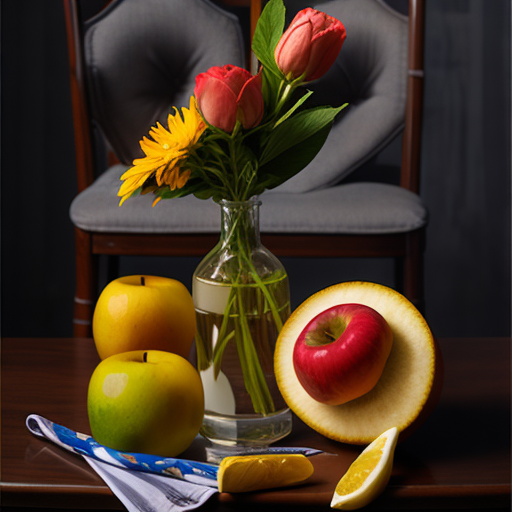

In [15]:
img = inference(
    control_image=Image.open("2259.png"),
    prompt="still life",
    negative_prompt="low quality, ugly",
    controlnet_conditioning_scale=0.95,
    control_guidance_start=0,
    control_guidance_end=1,
    seed=123456789,
)
img